# Setup

**Imports**

In [29]:
import datetime as dt
from math import log
import IPython

import matplotlib.pyplot as plt
import numpy as np
import ruptures as rpt

import seaborn as sns
from scipy.signal import chirp, spectrogram, stft, sweep_poly, find_peaks

from pygsp import graphs
from scipy.linalg import eigh
from scipy.spatial.distance import pdist, squareform
import re
from math import asin, cos, radians, sin, sqrt

import contextily as cx
import geopandas
import seaborn as sns

import utils
rng = np.random.default_rng()

# !pip install ruptures
import ruptures as rpt # we use the rupture package for change-point detection

# Question 1

The following cell loads the training data set `X_train` and `y_train`.
`X_train` is a list of 100 signals; `y_train` is a list of 100 symbol sequences. 

The signals have a varying number of symbols with a varying duration. 
There is a brief silence between each symbol.
The sampling frequency is $22.05 $ kHz.

In [3]:
FS = 22050  # sampling frequency (Hz)

X_train = np.load("X_train.npy", allow_pickle=True).tolist()
y_train = np.load("y_train.npy", allow_pickle=True).tolist()

In [4]:
signal, symbols = X_train[2], y_train[2]
print(" ".join(symbols))
IPython.display.Audio(signal, rate=FS)

D 6 A 8 3 D 1 8 B 9


### Dual-tone Multi-frequency Signaling

**Dual-tone multi-frequency signaling** is a procedure to encode symbols using an audio signal. The possible symbols are 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, *, #, A, B, C, and D. A symbol is represented by a sum of cosine waves: for \( t = 0, 1, \dots, T - 1 \),

$$
y_t = \cos\left( \frac{2\pi f_1 t}{f_s} \right) + \cos\left( \frac{2\pi f_2 t}{f_s} \right)
$$
where each combination of $(f_1, f_2)$ represents a symbol. The first frequency has four different levels (low frequencies), and the second frequency has four other levels (high frequencies); there are 16 possible combinations.

By reading the page from the [link](https://en.wikipedia.org/wiki/DTMF), we find the DTMF Keypad Frequencies (with sound clips) table:

|          | **1209 Hz** | **1336 Hz** | **1477 Hz** | **1633 Hz** |
|----------|---------|---------|---------|---------|
| **697 Hz** | 1       | 2       | 3       | A       |
| **770 Hz** | 4       | 5       | 6       | B       |
| **852 Hz** | 7       | 8       | 9       | C       |
| **941 Hz** | *       | 0       | #       | D       |

We store the characteristic frequencies :



In [ ]:
f1 = [697, 770, 852, 941] # low frequencies
f2 = [1209, 1336, 1477, 1633] # high frequencies

We have the following parameters, fixed in the rest of the question:

In [30]:
nperseg=512
n_overlap=256
Fs = 22050

In [33]:
def detect_frequency_line(index, spectrogram_seg, min_line_length=4, energy_threshold=0.3):
    intensity_at_freq = spectrogram_seg[index, :]
    above_threshold = intensity_at_freq > energy_threshold * np.max(intensity_at_freq)

    count = 0
    for val in above_threshold:
        if val:
            count += 1
            if count >= min_line_length:
                return True
        else:
            count = 0

    return False

def detect_change_points(Sxx, pen, num_breakpoints=None):
    model = rpt.Binseg(model="l2", jump=1).fit(signal=Sxx.T)

    if num_breakpoints is None:
        bkps = model.predict(pen=pen)
    else:
        breakpoints = model.predict(n_bkps=num_breakpoints)

    breakpoints.insert(0, 0) # insert the origin

    segments = []

    for i in range(len(breakpoints) - 1):
        seg = Sxx[:, breakpoints[i]:breakpoints[i+1]]
        segments.append(seg)

    return segments, breakpoints

def symbolize(segment_list, freq_list, energy_threshold):
    symbolisation = []
    pause_list = []
    max_id = len([value for value in freq_list if value <= f2[-1] + 50])

    for index, seg in enumerate(segment_list):
        seg_energy = np.mean(seg[:max_id + 1, :], axis=1)
        dominant_idx = np.argsort(seg_energy)[::-1][:2]

        valid_lines = [
            detect_frequency_line(index, seg, np.argmin(np.abs(freq_list - freq)), min_line_length=4, energy_threshold=energy_threshold)
            for freq in [freq_list[dominant_idx[0]], freq_list[dominant_idx[1]]]
        ]

        if not all(valid_lines):
            pause_list.append(True)
        else:
            pause_list.append(False)
            low_freq = min(f1, key=lambda fr: abs(min(freq_list[dominant_idx[0]], freq_list[dominant_idx[1]]) - fr))
            high_freq = min(f2, key=lambda fr: abs(max(freq_list[dominant_idx[0]], freq_list[dominant_idx[1]]) - fr))
            symbolisation.append((low_freq, high_freq))

    return symbolisation, pause_list

def filter_symbolisation(symbolisation, pause_list):

    filtered_symbolisation = []
    for i in range(len(symbolisation)):
        if i > 0 and symbolisation[i] == symbolisation[i - 1] and not pause_list[i]:
            filtered_symbolisation.append((None))
            continue
        filtered_symbolisation.append(symbolisation[i])
        
    symbolisation = filtered_symbolisation

    return filtered_symbolisation

def plot_spectrogram_and_symbolisation(t, f, Sxx, breakpoints, symbolisation):
    # Create the plots
    fig, ax = plt.subplots(figsize=(15, 10))

    
    # Plot the spectrogram (magnitude of STFT)
    im = ax.pcolormesh(t, f, Sxx, shading='gouraud', cmap='plasma')
    fig.colorbar(im, ax=ax, orientation="vertical", label="Magnitude (Spectrogram)")

    for b in breakpoints[:-1]:
        plt.axvline(t[b], c="y")
    for i in range(len(breakpoints) - 1):
        if i >= len(symbolisation) or symbolisation[i] is None:
            plt.plot([t[breakpoints[i] + 1], t[breakpoints[i + 1] - 1]], [f[0], f[0]], c="cyan", lw=1)
            plt.plot([t[breakpoints[i] + 1], t[breakpoints[i + 1] - 1]], [f[-1], f[-1]], c="cyan", lw=1)
        else:
            f1, f2 = symbolisation[i]
            plt.plot([t[breakpoints[i] + 1], t[breakpoints[i + 1] - 1]], [f1, f1], c="green", lw=1)
            plt.plot([t[breakpoints[i] + 1], t[breakpoints[i + 1] - 1]], [f2, f2], c="red", lw=1)

    ax.set_title("Spectrogram (Magnitude)")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Frequency (Hz)")
    ax.set_ylim(0, 5000)
    fig.colorbar(im, ax=ax, orientation="vertical", label="Magnitude (Spectrogram)")

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

In [34]:

def fit(signal, pen, energy_threshold, symbol_dic=None, num_breakpoints=None, determinist=False, plot=True):

    # compute spectrogram of the signal
    f, t, Sxx = spectrogram(signal, fs=Fs, noverlap=n_overlap,
                        nperseg=nperseg)

    # detect breakpoints in the spectrogram via change point algorithm
    segments, breakpoints = detect_change_points(Sxx, pen, num_breakpoints=None)

    # symbolise each segment and detect pauses
    symbolisation, pause_list = symbolize(segment_list=segments, freq_list=f, energy_threshold=energy_threshold)

    # filter segments to avoid pauses
    filtered_symbolisation = filter_symbolisation(symbolisation, pause_list)

    symbolisation = filtered_symbolisation

    if plot:
        plot_spectrogram_and_symbolisation(t, f, Sxx, breakpoints, symbolisation)


    if determinist:
        symbolisation = [item for item in symbolisation if item is not None]

    if symbol_dic is None:
        return symbolisation
    else:
        return [symbol_dic[x] for x in symbolisation if x is not None]

L'idée de méthodologie que nous retenons dans ce travail est la suivante : for each signal

1. **Time-Frequency Representation**: Convert the signal into a spectrogram using the Short-Time Fourier Transform (STFT). This helps identify the frequencies present in each segment of the signal.

2. **Change-Point Detection**: Analyze the spectrogram to identify boundaries where silence occurs, splitting the signal into segments corresponding to individual symbols.

3. **Frequency Extraction**: For each segment, identify the dominant low and high frequencies (e.g., via peak detection in the spectrogram).
Map these frequencies to the corresponding DTMF symbol using the known frequency-to-symbol mapping table.

4. **Classification**: Use the provided training data to fine-tune frequency thresholds and validate mappings.

5. **Hyperparameter Calibration**: Fine-tune STFT parameters like window size (e.g., 256 samples), overlap (50%), and FFT resolution.
Set energy thresholds for change-point detection and frequency peaks based on the noise levels in the training data.

On revient étape par étape sur la méthodologie que l'on adopte. 

1. **Time-Frequency Representation**

On commence par visualiser le spectrogramme pour le premier signal $\texttt{X\_train[0]}$

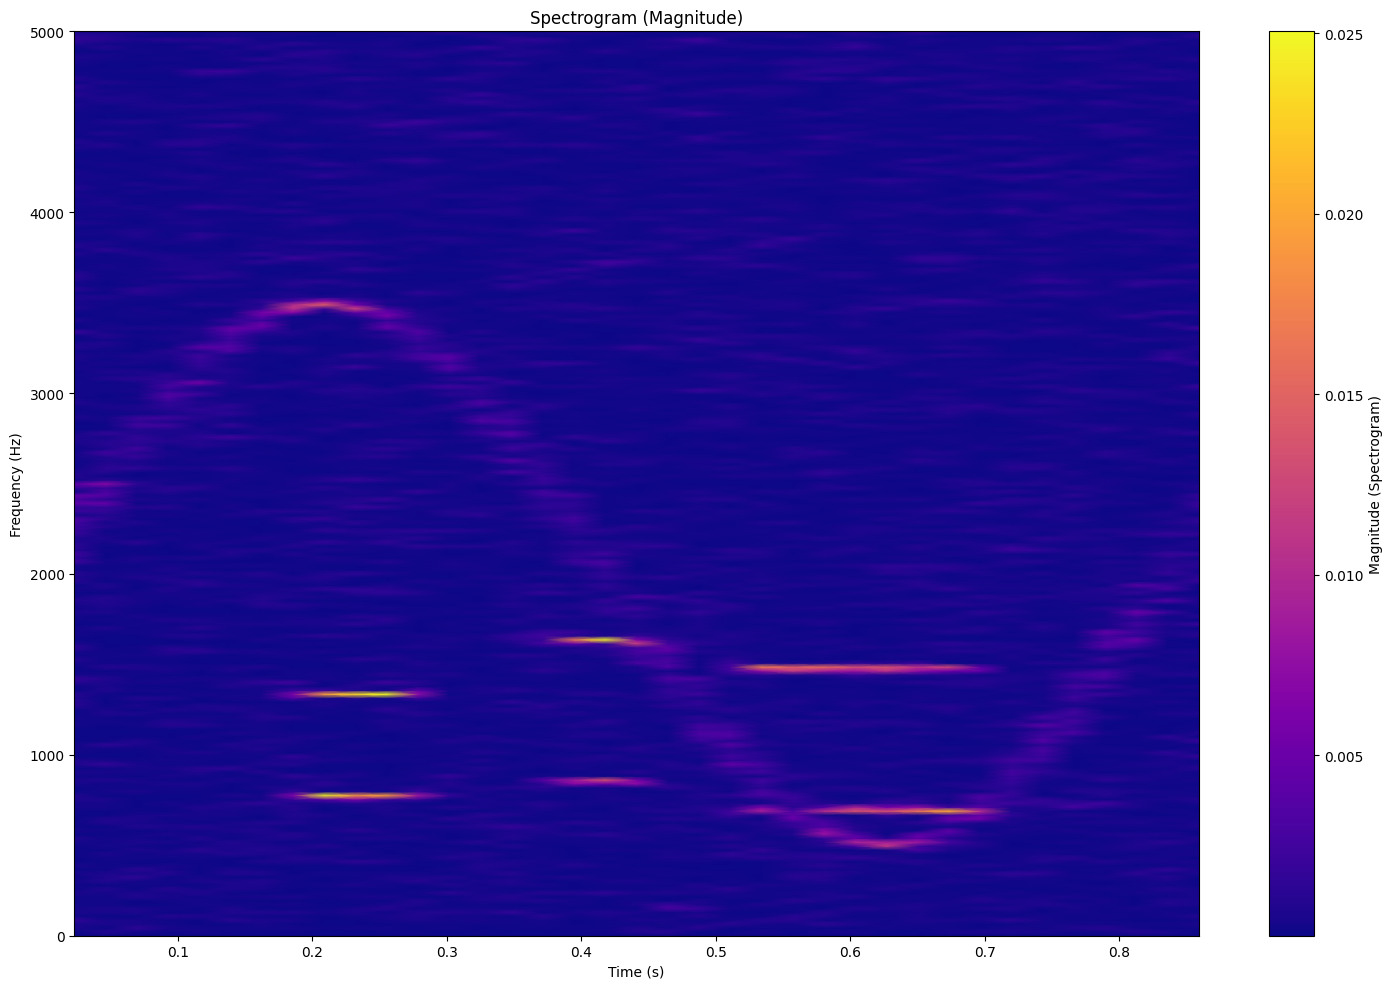

In [7]:
# Compute spectrogram and plot stft + spectrogram
def compute_spectrogram(signal, plot=True, window_size=1024, overlap=0.5):
    f, t, Sxx = spectrogram(signal, FS, nperseg=window_size, noverlap=int(window_size * overlap))
    
    if plot:
        # Create the plots
        fig, ax = plt.subplots(figsize=(15, 10))

        
        # Plot the spectrogram (magnitude of STFT)
        im = ax.pcolormesh(t, f, Sxx, shading='gouraud', cmap='plasma')
        ax.set_title("Spectrogram (Magnitude)")
        ax.set_xlabel("Time (s)")
        ax.set_ylabel("Frequency (Hz)")
        ax.set_ylim(0, 5000)
        fig.colorbar(im, ax=ax, orientation="vertical", label="Magnitude (Spectrogram)")

        # Adjust layout and show the plots
        plt.tight_layout()
        plt.show()
    
    return f, t, spectrogram

f, t, spectrogram = compute_spectrogram(X_train[0])

On observe trois segments et, en observant la symbolisation de ce signal dans $\texttt{y\_train[10]}$, on observe bien une symbolisation en trois symboles. 

In [8]:
y_train[0]

['5', 'C', '3']

2. **Change-Point Detection**

The idea is now to analyze the spectrogram to identify boundaries where silence occurs, splitting the signal into segments corresponding to individual symbols. To do so, we use energy thresholds or a suitable change-point detection algorithm to detect silent gaps.

In [9]:
def detect_change_points(signal, window_size = 512, overlap=0.5, plot=True):
    """
    Detect change points in the signal based on the energy computed from the spectrogram.
    
    Parameters:
        signal (numpy array): The input signal.
        num_symbols (int): The number of symbols (segments) expected.
        penalty (float): Penalty for change-point detection (controls sensitivity).
        window_size(int): default = 1024 - Window size for the STFT
        overlap (float): default = 0.5 - 50% overlap
    Returns:
        breakpoints (list): The indices of the detected change points.
    """
    # Compute the spectrogram of the signal
    f, t, Sxx = spectrogram(signal, FS, nperseg=window_size, noverlap=int(window_size * overlap))
    
    
    # Apply the Dynp algorithm to detect change points
    pen_bic = 0.001 * sigma**2 * np.log(len(signal))
    algo = rpt.Pelt(model="l1", jump=1, min_size=2)
    breakpoints = algo.fit_predict(signal=Sxx.T, pen=pen_bic)
    
    # Compute the energy of the spectrogram (summed across frequency bins)
    energy = np.sum(Sxx ** 2, axis=0)

    # Get the time stamps corresponding to the change points
    time_stamps = [t[bkps - 1] for bkps in breakpoints]

    if plot: 
        fig, ax = plt.subplots(figsize=(15, 10))

        # Plot the spectrogram (magnitude of STFT)
        im = ax.pcolormesh(t, f, Sxx, shading='gouraud', cmap='plasma')

        ax.set_title("Spectrogram (Magnitude)")
        ax.set_xlabel("Time (s)")
        ax.set_ylabel("Frequency (Hz)")
        ax.set_ylim(0, 5000)
        fig.colorbar(im, ax=ax, orientation="vertical", label="Magnitude (Spectrogram)")

        # Add vertical lines at the change points
        for timestamp in time_stamps:
            ax.axvline(x=timestamp, color='red', linestyle='--', linewidth=2)

        # Adjust layout and show the plots
        plt.tight_layout()
        plt.show()

    return breakpoints, time_stamps



In [ ]:
# Example usage for a single signal
signal = X_train[10]  # Example: Use the first signal from X_train
num_symbols = len(y_train[10])+1  # The number of symbols for this signal (from Y_train)

# Detect change points
breakpoints, time_stamps = detect_change_points(signal, num_symbols)

On voit que l'on a trop de chane-point en utilisant uniquement l'algorithme PELT sans contraintes sur le nombre de breakpoints. Pour chaque signal $\texttt{len(X\_train[i])}$ on devrait avoir $\texttt{len(y\_train[i])}$ breakpoints. C'est la raison pour laquelle on va utiliser un critère de silence pour exclure certains points et nous allons également fusionner certains intervalles s'ils correspondent aux mêmes symboles. 

Plusieurs remarques : 
- La table des fréquences DTMF (que l'on rappelle ci-après) ne tient que pour certaines fréquences, il convient donc de s'intéresser à celles-ci (on fixe une fréquence minimale $\texttt{min\_freq = 650}$ et $\texttt{max\_freq = 1700}$ à la lecture de la table suivante).

|          | **1209 Hz** | **1336 Hz** | **1477 Hz** | **1633 Hz** |
|----------|---------|---------|---------|---------|
| **697 Hz** | 1       | 2       | 3       | A       |
| **770 Hz** | 4       | 5       | 6       | B       |
| **852 Hz** | 7       | 8       | 9       | C       |
| **941 Hz** | *       | 0       | #       | D       |

- Pareillement, la table ci-dessus donne l'amplitude minimale et l'amplitude maximale de chaque intervalle définissant un symbole. On a pour le minimum $1209 - 697=512$ et pour le maximum $1633-941=692$ donc on fixe $\texttt{min\_freq\_dist = 300}$ et $\texttt{max\_freq\_dist = 800}$.

- Il semblerait, à la lecture du premier spectrogramme, que les segments correspondent ou bien à des zones de silences, ou bien à des zones à forte magnitude. C'est la raison pour laquelle on se propose d'étudier l'**énergie** du signal pour trouver ces zones. Elle y est soit très faible (silence) soit très forte (forte magnitude, pic).

- On stocke dans deux arrays les fréquences possibles pour $f_1$ et $f_2$.

- On stocke visuellement que le temps minimal de séparation est d'environ $0.2$.

- On a testé plusieurs valeurs possibles pour le seuil minimal de l'énergie, et on a retenu $0.1$

In [11]:
f1 = np.array([697, 770, 852, 941])
f2 = np.array([1209, 1336, 1477, 1633])

In [12]:
# Helper function to compute the spectrogram
def compute_spectrogram(signal, window_size, overlap):
    f, t, Sxx = spectrogram(signal, FS, nperseg=window_size, noverlap=int(window_size * overlap))
    return f, t, Sxx

# Helper function to identify frequency indices of interest
def get_frequency_indices(f, min_freq, max_freq):
    idx_min_freq = np.argmin(np.abs(f - min_freq))
    idx_max_freq = np.argmin(np.abs(f - max_freq))
    return idx_min_freq, idx_max_freq

# Helper function to apply the Dynp algorithm for change point detection
def detect_change_points(Sxx):
    pen_bic = 0.001 * sigma**2 * np.log(len(Sxx))
    algo = rpt.Pelt(model="l1", jump=1, min_size=2)
    breakpoints = algo.fit_predict(signal=Sxx.T, pen=pen_bic)
    return breakpoints

# Helper function to extract and analyze energy in the spectrogram
def compute_energy(Sxx):
    return np.sum(Sxx ** 2, axis=0)

# Helper function to process each segment of the signal
def process_segment(f, t, Sxx, breakpoints, idx_min_freq, idx_max_freq, min_freq_dist, max_freq_dist):
    time_stamps_seg = []
    
    for idx_bkp in range(0, len(breakpoints[:-2]), 2):
        start_time = t[breakpoints[idx_bkp]]
        end_time = t[breakpoints[idx_bkp + 1]] if breakpoints[idx_bkp + 1] < len(t) else t[-1]

        # Extract the spectrogram segment of interest
        Sxx_zone = Sxx[idx_min_freq:idx_max_freq, breakpoints[idx_bkp]:breakpoints[idx_bkp + 1]]
        
        # Compute energy for the segment
        energy = np.mean(Sxx_zone, axis=1)
        
        # Identify the two frequencies with the highest energy
        freqs = f[idx_min_freq + np.argsort(energy)[-2:]]
        
        # Check if frequencies are within the acceptable distance
        if np.abs(freqs[0] - freqs[1]) < min_freq_dist or np.abs(freqs[0] - freqs[1]) > max_freq_dist:
            continue
        
        # Compute the closest DTMF frequencies
        pred_f1, pred_f2 = match_dtmf_frequencies(freqs)
        
        # Append the detected segment with its properties
        time_stamps_seg.append({
            "freqs": freqs,
            "symbol": DTMF_freq_map[(f1[pred_f1], f2[pred_f2])],
            "start_time": start_time,
            "end_time": end_time,
            "energy": np.sum(np.sort(energy)[-2:]) / (end_time - start_time),
        })
    
    return time_stamps_seg

# Helper function to match DTMF frequencies
def match_dtmf_frequencies(freqs):
    distances_f1 = np.min(np.abs(f1[:None, None] - freqs[None, None, :]), axis=(0, 2))
    distances_f2 = np.min(np.abs(f2[:None, None] - freqs[None, None, :]), axis=(0, 2))
    pred_f1 = np.argmin(distances_f1)
    pred_f2 = np.argmin(distances_f2)
    return pred_f1, pred_f2

# Helper function to merge segments based on proximity and symbol
def merge_segments(segments, min_break_time):
    merged_segments = [segments[0]]
    
    for next_segment in segments[1:]:
        if next_segment["symbol"] == merged_segments[-1]["symbol"] and \
           next_segment["start_time"] - merged_segments[-1]["end_time"] < min_break_time:
            merged_segments[-1]["end_time"] = next_segment["end_time"]
        else:
            merged_segments.append(next_segment)
    
    return merged_segments

# Helper function to filter segments based on energy threshold
def filter_segments_by_energy(segments, energy_threshold):
    return [segment for segment in segments if segment["energy"] > energy_threshold]

# Main function to detect change points
def detect_change_points_adjusted(signal, energy_threshold, min_break_time, min_freq = 650, max_freq = 1700, window_size=512, overlap=0.5, plot=True):
    min_freq = 650
    max_freq = 1700
    min_freq_dist = 250
    max_freq_dist = 950

    # Step 1: Compute the spectrogram
    f, t, Sxx = compute_spectrogram(signal, window_size, overlap)
    
    # Step 2: Get frequency indices of interest
    idx_min_freq, idx_max_freq = get_frequency_indices(f, min_freq, max_freq)
    
    # Step 3: Detect change points using Dynp algorithm
    breakpoints = detect_change_points(Sxx)
    
    # Step 4: Process the segments of the signal
    time_stamps_seg = process_segment(f, t, Sxx, breakpoints, idx_min_freq, idx_max_freq, min_freq_dist, max_freq_dist)
    
    # Step 5: Merge segments if they are close and have the same symbol
    merged_segments = merge_segments(time_stamps_seg, min_break_time)
    
    # Step 6: Filter segments by energy threshold
    final_segments = filter_segments_by_energy(merged_segments, energy_threshold)
    
    if plot: 
        fig, ax = plt.subplots(figsize=(15, 10))

        # Plot the spectrogram (magnitude of STFT)
        im = ax.pcolormesh(t, f, Sxx, shading='gouraud', cmap='plasma')

        ax.set_title("Spectrogram (Magnitude)")
        ax.set_xlabel("Time (s)")
        ax.set_ylabel("Frequency (Hz)")
        ax.set_ylim(0, 5000)
        fig.colorbar(im, ax=ax, orientation="vertical", label="Magnitude (Spectrogram)")

        # Add vertical lines at the change points
        for segment in final_segments:
            ax.axvline(x=segment['start_time'], color='red', linestyle='--', linewidth=2)
            ax.axvline(x=segment['end_time'], color='red', linestyle='--', linewidth=2)

        # Adjust layout and show the plots
        plt.tight_layout()
        plt.show()

    symbolisation = [segment["symbol"] for segment in final_segments]

    return symbolisation, final_segments

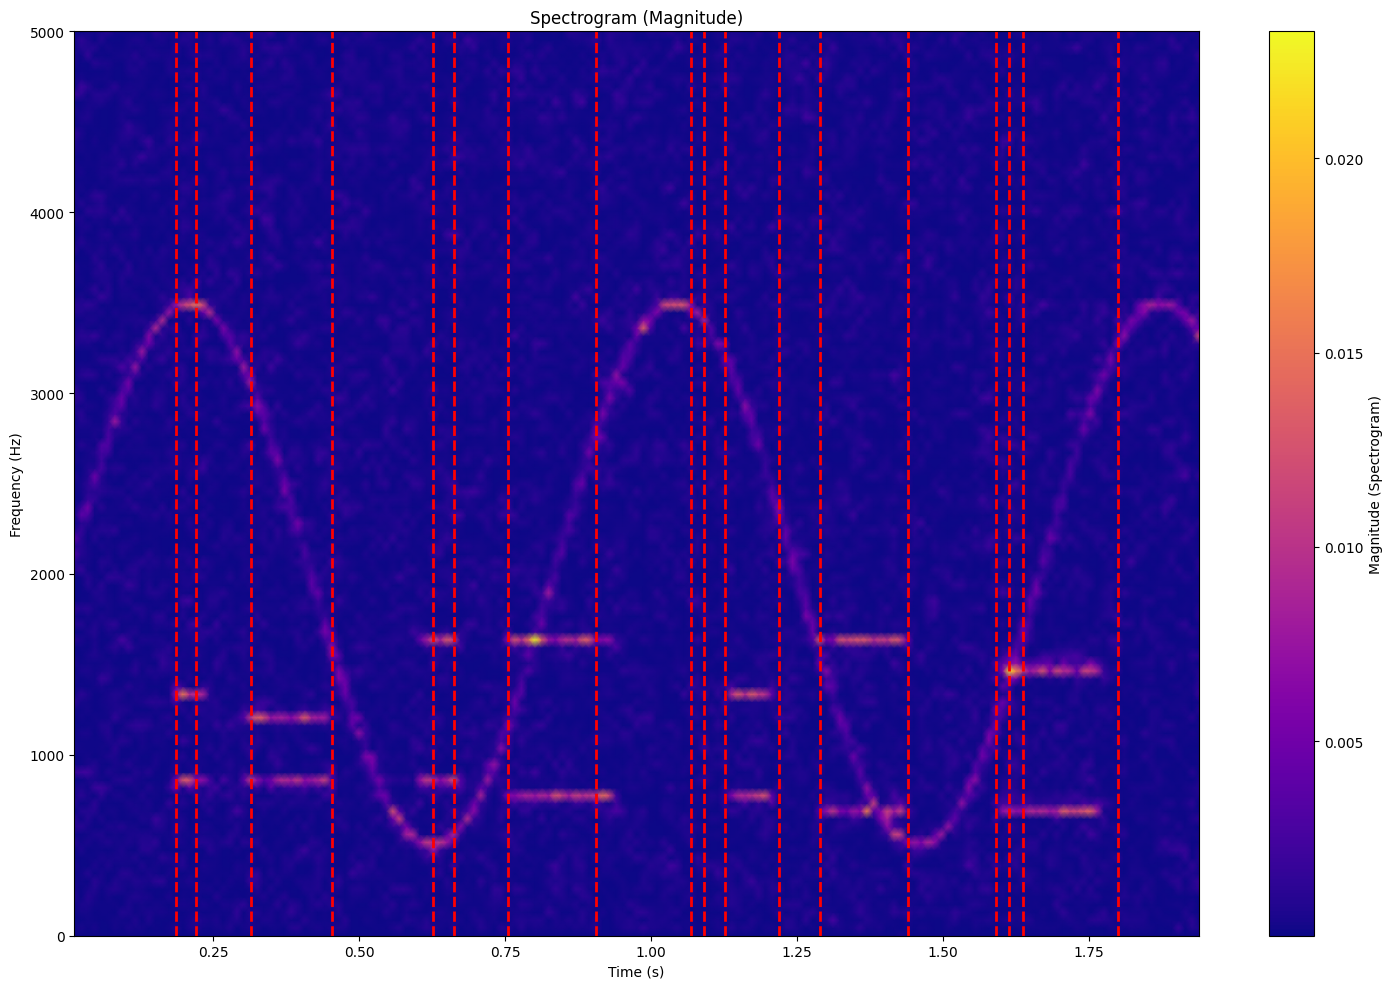

In [13]:
# Detect change points
symbolisation, final_segments = detect_change_points_adjusted(X_train[1], min_break_time=0.2, min_freq = 600, max_freq = 1800, energy_threshold=0.10)

This is much better ! Let's look at the accuracy over the training set $\texttt{X\_train}$.

In [ ]:
# Lists of break_time and energy thresholds to test
break_time = [0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.25, 0.3]
energy = [0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.25, 0.3]

# To store the results for each combination of break_time and energy
accuracy_results = {}

# Iterate over break_time and energy thresholds
for time in break_time:
    for threshold in energy:
        accuracy = 0
        # Loop through each training sample
        for i in range(len(X_train)):
            symbolisation, _ = detect_change_points_adjusted(X_train[i], min_break_time=time, energy_threshold=threshold, plot=False)
            # If predicted symbolisation matches the true label, increment accuracy
            if symbolisation == y_train[i]:
                accuracy += 1
        
        # Store the accuracy for the current combination of time and threshold
        accuracy_results[(time, threshold)] = accuracy

# Find the combination of break_time and energy that gave the highest accuracy
best_combination = max(accuracy_results, key=accuracy_results.get)
best_accuracy = accuracy_results[best_combination]

# Output the best break_time, energy, and their corresponding accuracy
best_break_time, best_energy = best_combination
print(f"Best break_time: {best_break_time}, Best energy threshold: {best_energy}")
print(f"Best combined accuracy: {best_accuracy}")

On fixe donc Best break_time = 0.05 et energy threshold = 0.15

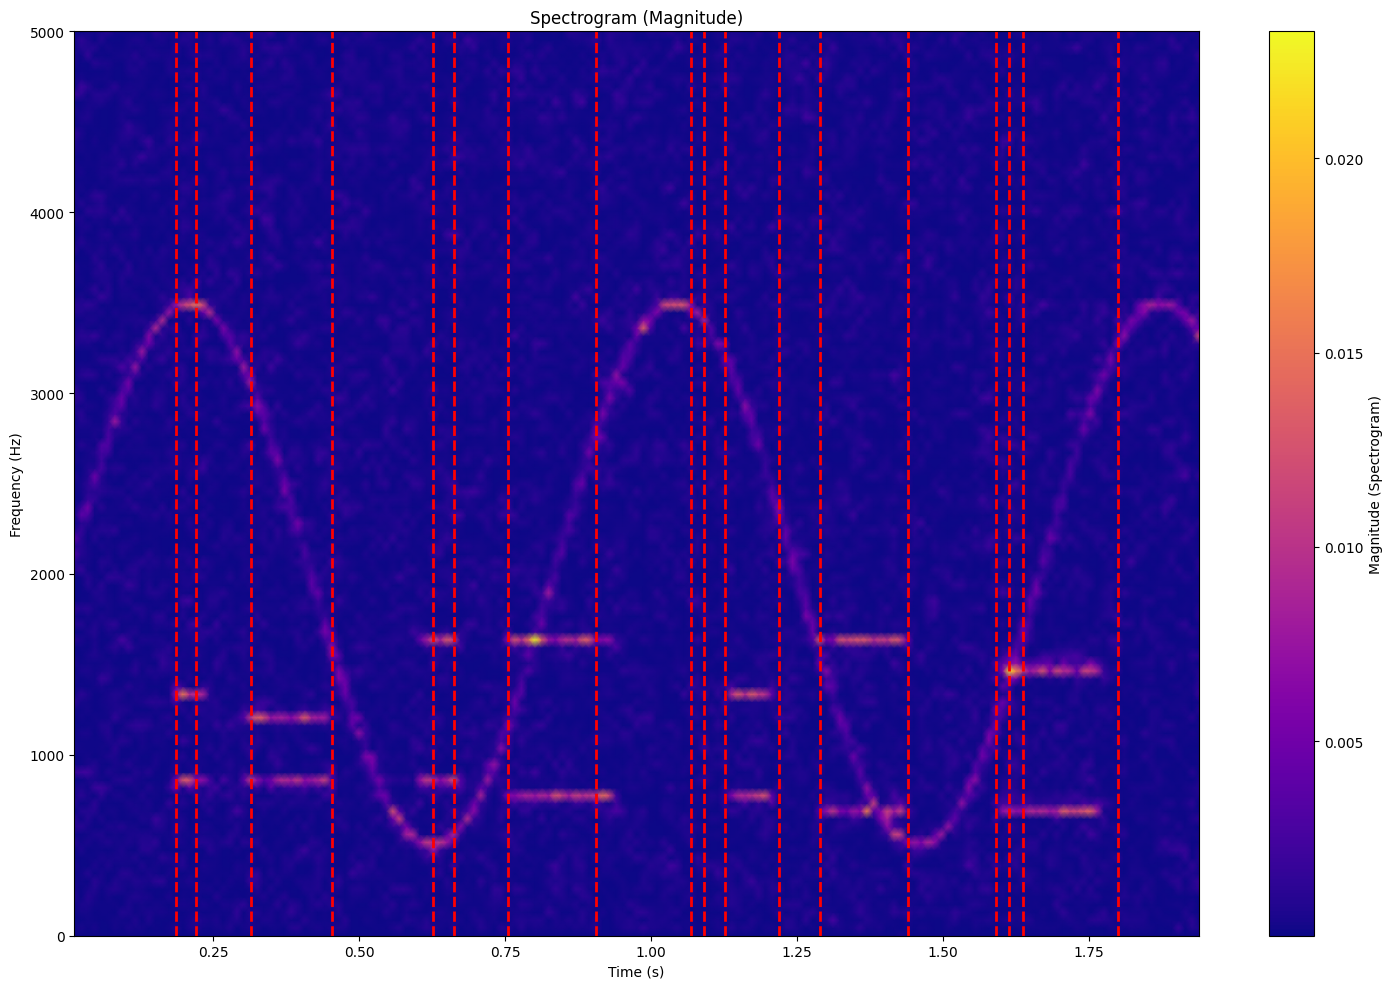

In [15]:
symbolisation, final_segments = detect_change_points_adjusted(X_train[1], min_break_time=0.2, energy_threshold=0.10)

# Question 2

In [16]:
X_test = np.load("X_test.npy", allow_pickle=True).tolist()

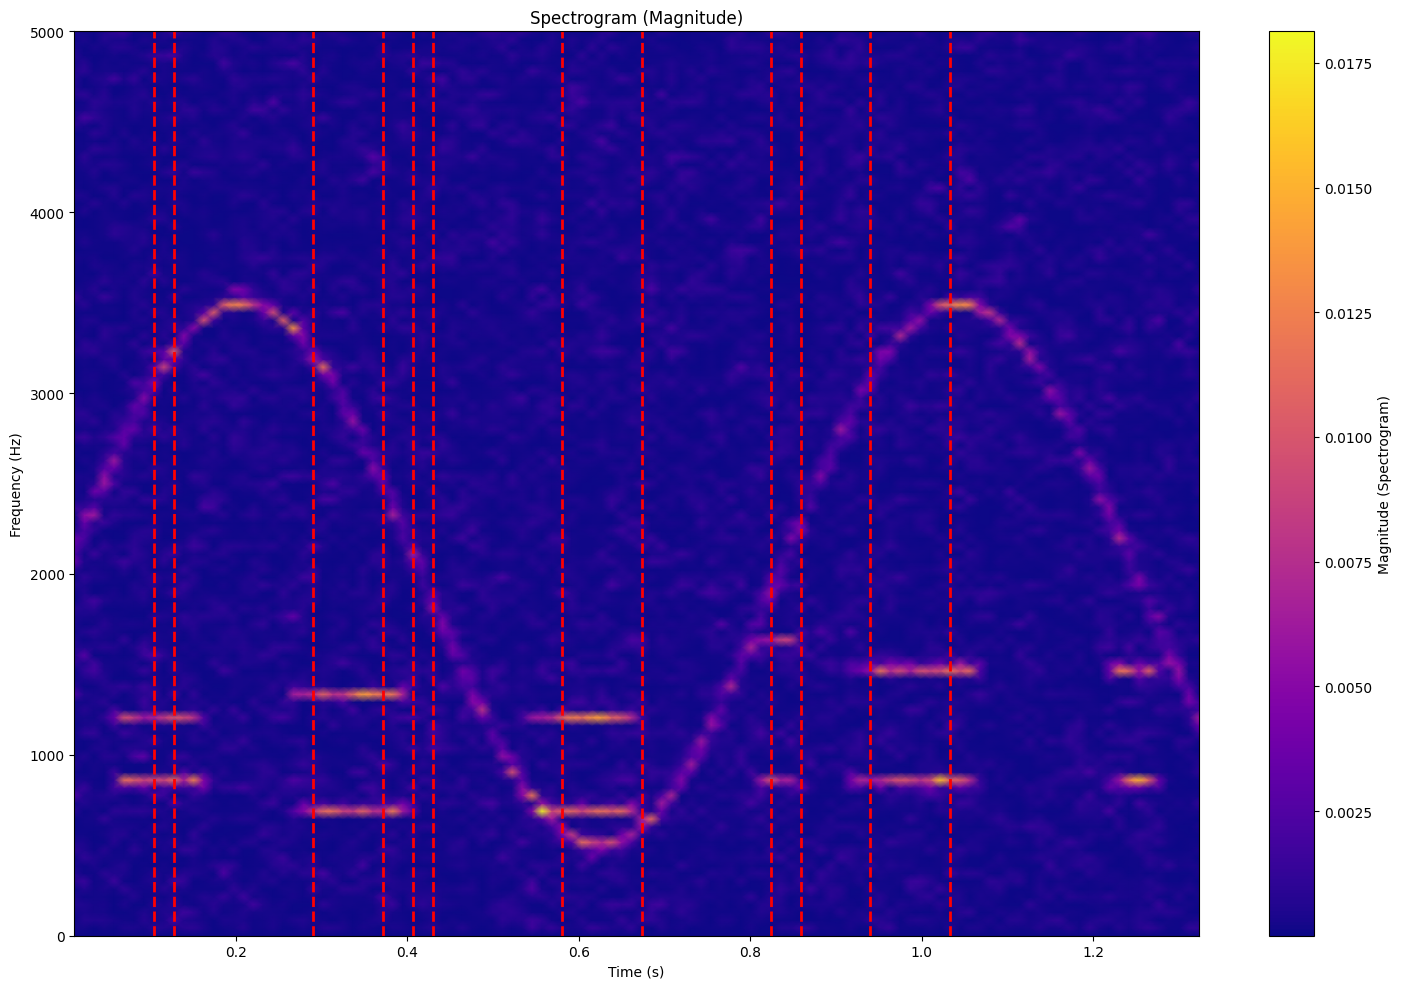

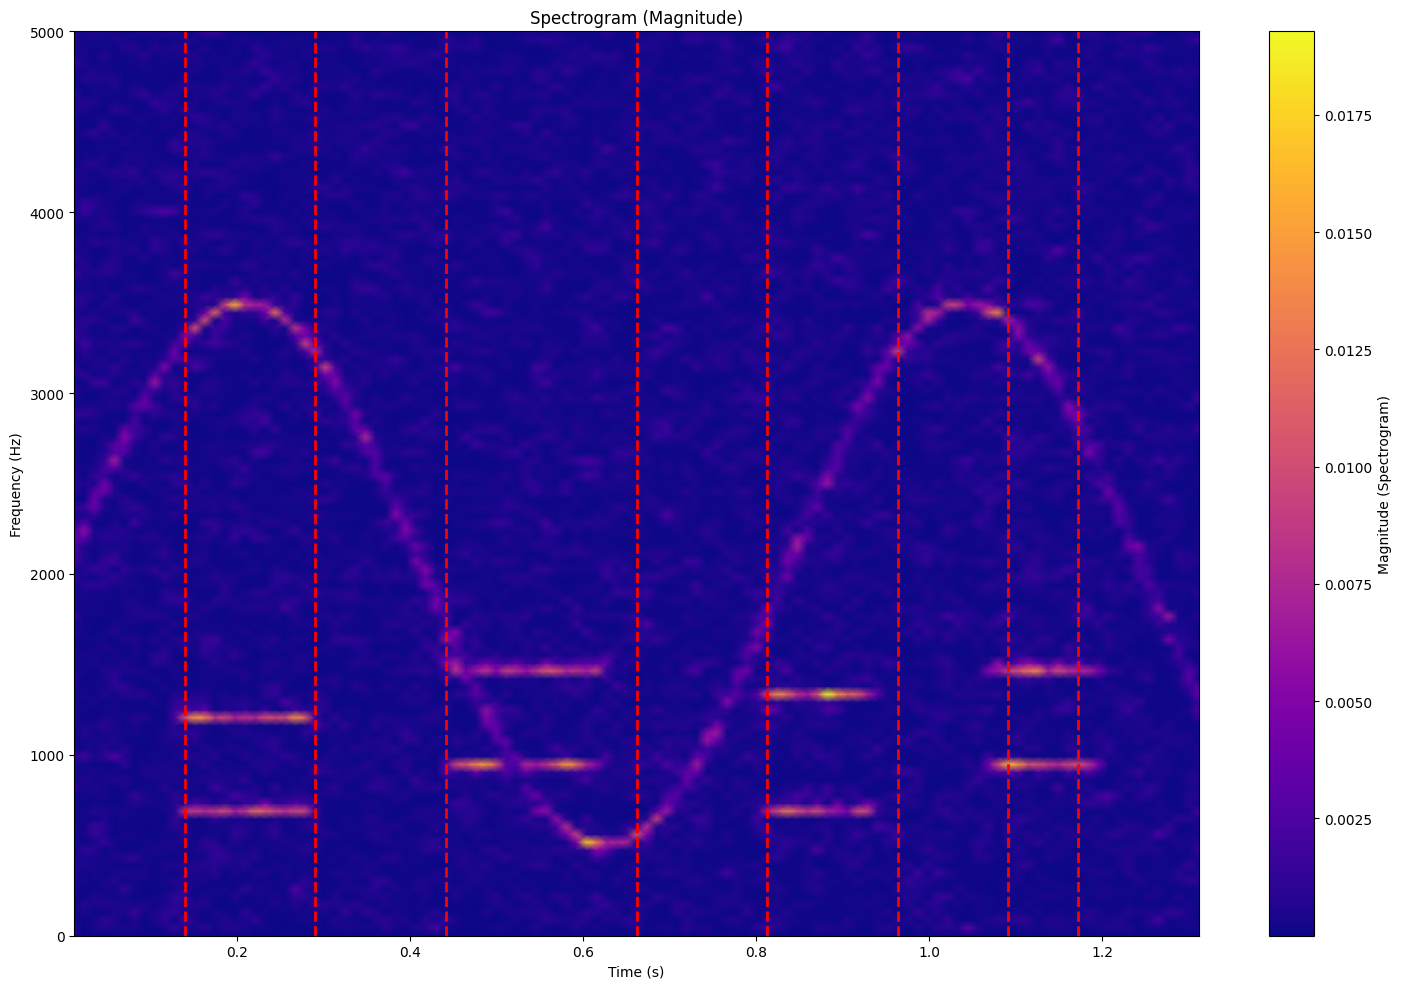

symbolisation échantillon test 0 : ['7', '2', '1', '1', 'C', '9']
symbolisation échantillon test 1 : ['1', '#', '2', '#']


In [17]:
symbolisation_0, _ = detect_change_points_adjusted(X_test[0], min_break_time=0.05, energy_threshold=0.10, plot=True)
symbolisation_1, _ = detect_change_points_adjusted(X_test[1], min_break_time=0.05, energy_threshold=0.10, plot=True)
print(f'symbolisation échantillon test 0 : {symbolisation_0}')
print(f'symbolisation échantillon test 1 : {symbolisation_1}')

# Question 3

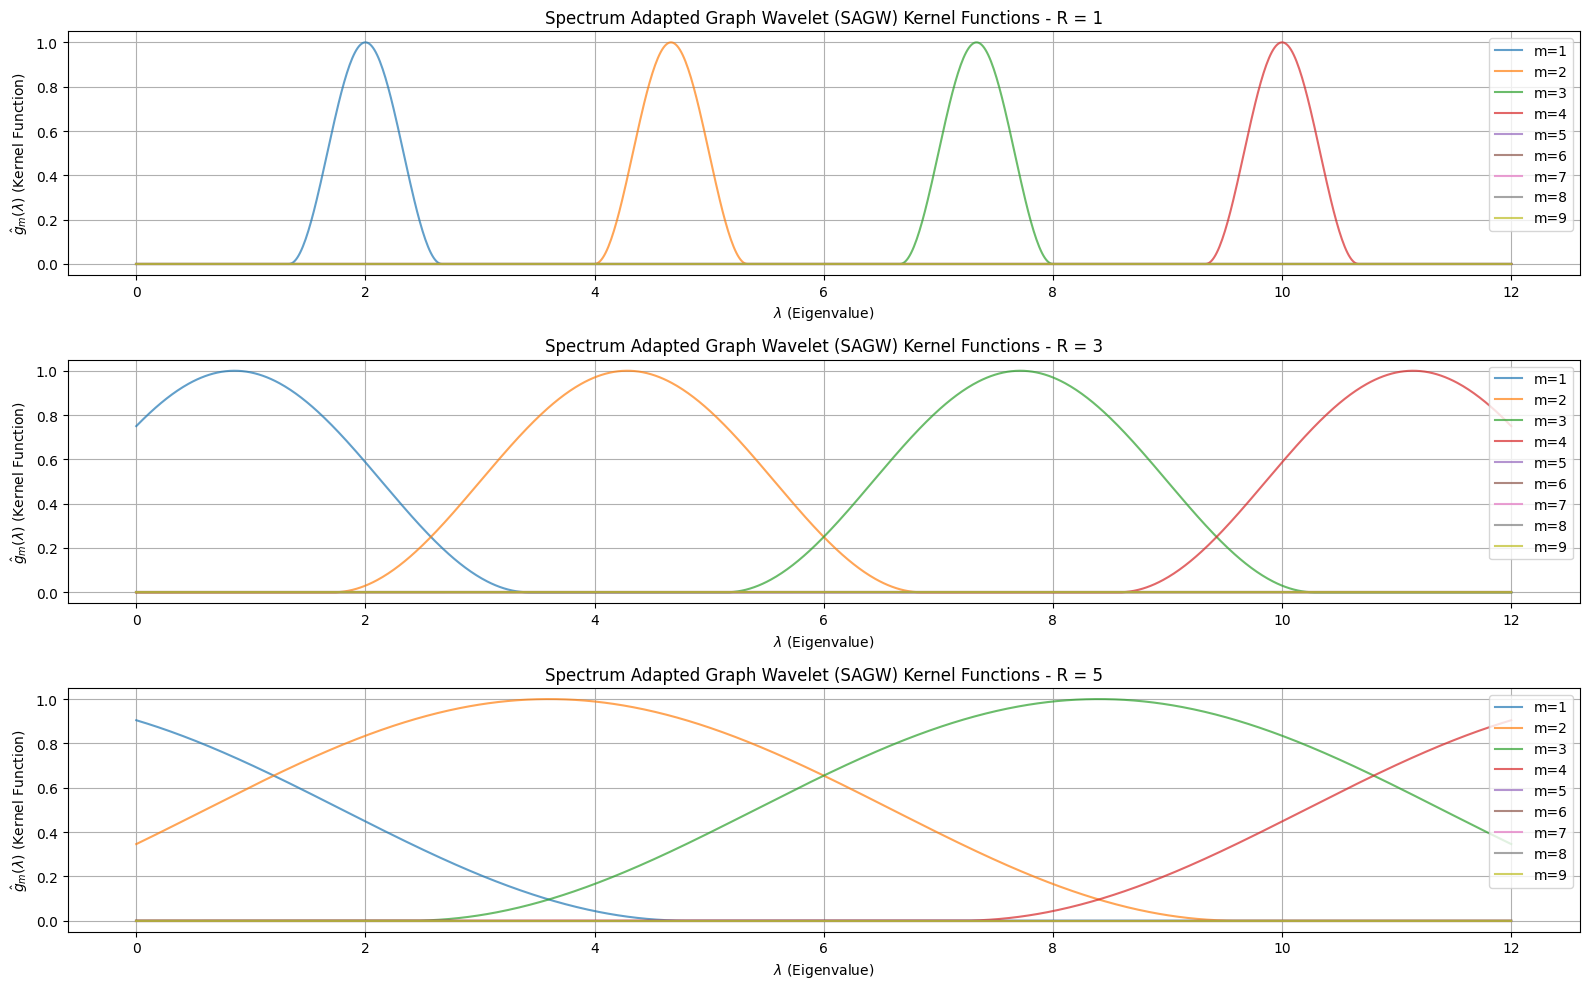

In [19]:
# Define the parameters
lambda_n = 12  # Maximum eigenvalue of the graph Laplacian
M = 9          # Number of scales
R_values = [1, 3, 5]         # Different values of R to plot
lambda_vals = np.linspace(0, lambda_n, 1000)  # Range of eigenvalue lambda for plotting

# Define the base kernel function g^U(lambda)
def g_U(lambda_val, R):
    a = lambda_n / (M + 1 - R)
    return 0.5 * (1 + np.cos(2 * np.pi * (lambda_val / (a * R) + 0.5))) * (lambda_val >= -a * R) * (lambda_val < 0)

# Define the shifted kernel functions g_m(lambda)
def g_m(lambda_val, m, R):
    a = lambda_n / (M + 1 - R)
    return g_U(lambda_val - a * m, R)

# Create the figure and axis
fig, ax = plt.subplots(len(R_values), 1, figsize=(16, 10))

# Plotting the kernels for different R values
for index, R in enumerate(R_values):
    # Generate the kernel functions for all m = 1 to M
    a = lambda_n / (M + 1 - R)
    for m in range(1, M + 1):
        kernel_values = np.array([g_m(l - a * m,m, R) for l in lambda_vals])
        ax[index].plot(lambda_vals, kernel_values, label=f'm={m}', alpha=0.7)
        ax[index].set_title(f"Spectrum Adapted Graph Wavelet (SAGW) Kernel Functions - R = {R}")
        ax[index].set_xlabel(r"$\lambda$ (Eigenvalue)")
        ax[index].set_ylabel(r"$\hat{g}_m(\lambda)$ (Kernel Function)")
        ax[index].grid(True)

        # Display legend and show the plot
        ax[index].legend()

plt.tight_layout()
plt.show()

# Question 4

On récupère le code des fonctions du dernier TP

In [20]:
CRS = "EPSG:4326"

In [21]:
data, station_metadata, temperature_data = utils.load_data()
# Remove all stations with missing values in the temperature data.
stations_with_nan = temperature_data.columns[temperature_data.isna().any()].tolist()
valid_stations = list(set(temperature_data.columns) - set(stations_with_nan))
print(f"Stations containing at least one NaN value: {stations_with_nan}")

# Convert pandas DataFrame to GeoPandas GeoDataFrame
station_geodata = geopandas.GeoDataFrame(
    station_metadata,
    geometry=geopandas.points_from_xy(station_metadata.Longitude, station_metadata.Latitude),
).set_crs(CRS)

Stations containing at least one NaN value: ['ARZAL', 'BATZ', 'BEG_MEIL', 'BREST-GUIPAVAS', 'BRIGNOGAN', 'CAMARET', 'LANDIVISIAU', 'LANNAERO', 'LANVEOC', 'OUESSANT-STIFF', 'PLOUAY-SA', 'PLOUDALMEZEAU', 'PLOUGONVELIN', 'QUIMPER', 'RIEC SUR BELON', 'SIZUN', 'ST NAZAIRE-MONTOIR', 'VANNES-MEUCON']


Optimal Threshold: 0.8478
The graph is connected, with average degree 6.29


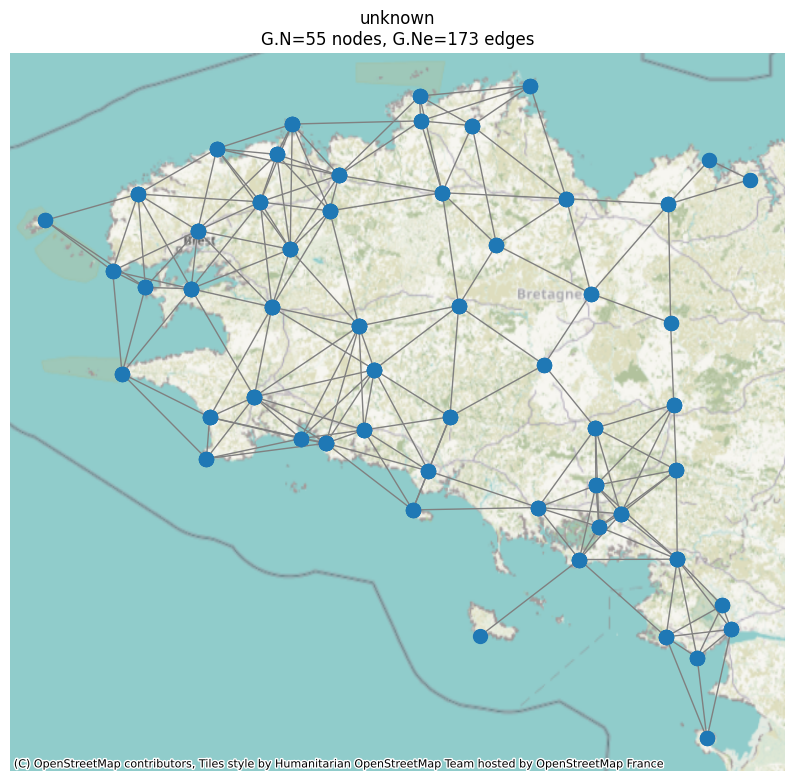

In [22]:
# Compute the distance matrix
station_coordinates = station_metadata[["Longitude", "Latitude"]].to_numpy()
pairwise_distances = pdist(station_coordinates, metric=utils.get_geodesic_distance)
distance_median = np.median(pairwise_distances)  # Median heuristic for sigma

# Find the maximum threshold of a connected graph
distance_thresholds = np.linspace(1, 0, 1000)
optimal_threshold = 0
for i in range(len(distance_thresholds)):
    gaussian_similarity_matrix = squareform(
        utils.get_exponential_similarity(pairwise_distances, distance_median, distance_thresholds[i])
    )
    graph = graphs.Graph(gaussian_similarity_matrix)
    if graph.is_connected(recompute=True) and np.mean(graph.d) > 3:
        optimal_threshold = distance_thresholds[i]
        break

print("Optimal Threshold: {:.4f}".format(optimal_threshold))
print(
    f"The graph is {'not ' if not graph.is_connected(recompute=True) else ''}connected, "
    f"with average degree {np.mean(graph.d):.2f}"
)

# Plot the stations on a map with the graph overlay
ax = station_geodata.geometry.plot(figsize=(10, 10))
cx.add_basemap(ax, crs=station_geodata.crs.to_string(), zoom=8)
ax.set_axis_off()
graph.set_coordinates(station_coordinates)
graph.plot(ax=ax)


In [23]:
laplacian_matrix = graph.L.todense()
signal_smoothness = []

# Calculate smoothness for each temperature signal
for day_index in range(len(temperature_data)):
    signal_smoothness.append(
        temperature_data.iloc[day_index].T @ laplacian_matrix @ temperature_data.iloc[day_index]
    )
signal_smoothness = np.array(signal_smoothness)

# Identify the days with minimum and maximum smoothness
day_with_min_smoothness = np.argmin(signal_smoothness)
day_with_max_smoothness = np.argmax(signal_smoothness)

# Print smoothness statistics
print("Average smoothness: {:.2f}".format(np.mean(signal_smoothness)))
print("Day with least smoothness: {}".format(temperature_data.index[day_with_max_smoothness]))
print("Day with highest smoothness: {}".format(temperature_data.index[day_with_min_smoothness]))

Average smoothness: nan
Day with least smoothness: 2014-01-01 00:00:00
Day with highest smoothness: 2014-01-01 00:00:00


# Question 5

# Question 6

# Question 7